<a href="https://colab.research.google.com/github/AhmedEloumi/Power-consumption-efficient-interpretation/blob/master/energy_consumption_predection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download uciml/electric-power-consumption-data-set

 67% 13.0M/19.4M [00:00<00:00, 134MB/s]
100% 19.4M/19.4M [00:00<00:00, 168MB/s]


In [ ]:
!unzip /content/electric-power-consumption-data-set.zip -d power

Archive:  /content/electric-power-consumption-data-set.zip
  inflating: power/household_power_consumption.txt  


In [ ]:
#! pip install git+https://github.com/RJT1990/pyflux

In [ ]:
# Import necessary libraries and packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set floating point precision option for pandas
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Import seaborn library and set context and style
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

# Import warnings and set filter to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import time library
from time import time

# Import matplotlib ticker and scipy stats
import matplotlib.ticker as tkr
from scipy import stats

# Import statistical tools for time series analysis
from statsmodels.tsa.stattools import adfuller

# Import preprocessing from sklearn
from sklearn import preprocessing

# Import partial autocorrelation function from statsmodels
from statsmodels.tsa.stattools import pacf

# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# Import math library
import math

# Import necessary functions from keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *

# Import MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Import mean squared error and mean absolute error from sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Import early stopping from keras callbacks
from keras.callbacks import EarlyStopping

####**1.Data Understanding**

In [ ]:
df= pd.read_csv("/content/power/household_power_consumption.txt",delimiter=';')

In [ ]:
# Display the columns of the dataframe
for i in range(len(df.columns)):
    print(df.columns[i])

# Get the information about the dataframe
print("\nInformation about the dataframe:")
print(df.info())
shape=df.shape

# Print the number of rows and columns in the data
print('\nNumber of rows and columns:',shape)

Date
Time
Global_active_power
Global_reactive_power
Voltage
Global_intensity
Sub_metering_1
Sub_metering_2
Sub_metering_3

Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB
None

Number of rows and columns: (2075259, 9)


In [ ]:
# Display the first 5 rows of the data
df.head() #df.head(5)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


####**2.Data Cleaning**

In [ ]:
#convert all the attributes to numeric format
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

In [ ]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
# by combining the two columns and converting to datetime format
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

In [ ]:
# Drop the original 'Date' and 'Time' columns
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [ ]:
# Convert the 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

In [ ]:
# Get the information about the dataframe
print("\nInformation about the dataframe:")
print(df.info())


Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float64       
 1   Global_reactive_power  float64       
 2   Voltage                float64       
 3   Global_intensity       float64       
 4   Sub_metering_1         float64       
 5   Sub_metering_2         float64       
 6   Sub_metering_3         float64       
 7   date_time              datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB
None


In [ ]:
#find the missing and duplicated values
#remove them
print('The number of missing values in each attribute :\n\n',df.isnull().sum())

print('\nThe number of duplicated values :', sum(df.duplicated()))
df1=df.copy()
df1=df1.dropna()

print ('\nThe number of rows become', df1.shape[0], 'instead of', df.shape[0], 'after removing NaN values')

The number of missing values in each attribute :

 Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
date_time                    0
dtype: int64

The number of duplicated values : 0

The number of rows become 2049280 instead of 2075259 after removing NaN values


####**Find outilers**

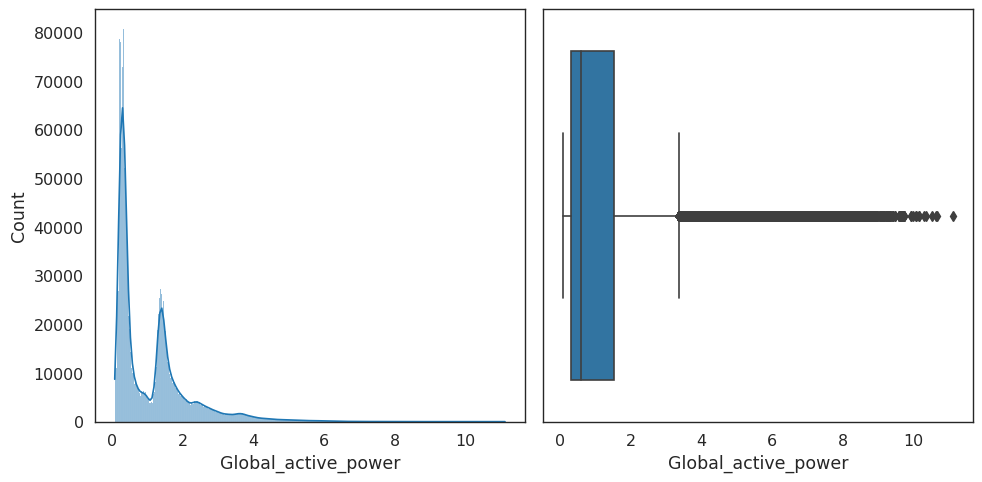

In [ ]:
# Create a 1x2 grid for the subplots (1 row, 2columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the distribution of each power in separate subplots
sns.histplot(df['Global_active_power'], kde=True, ax=axes[0])


# Box Plot
sns.boxplot(x=df['Global_active_power'], ax=axes[1])


# Show the plot
plt.tight_layout()
plt.show()

###removing outliers using Z-score method

In [ ]:
# Function to remove outliers using Z-score for one attribute
def remove_outliers_zscore(data, column, threshold=3):
    z_scores = np.abs((data[column] - data[column].mean()) / data[column].std())
    return data[z_scores < threshold]

# Specify the attribute column for which you want to remove outliers
attribute_column = 'Global_active_power'

# Remove outliers from the DataFrame for the specified attribute
df3 = remove_outliers_zscore(df1, attribute_column)

In [ ]:
df3.shape

(2013120, 8)

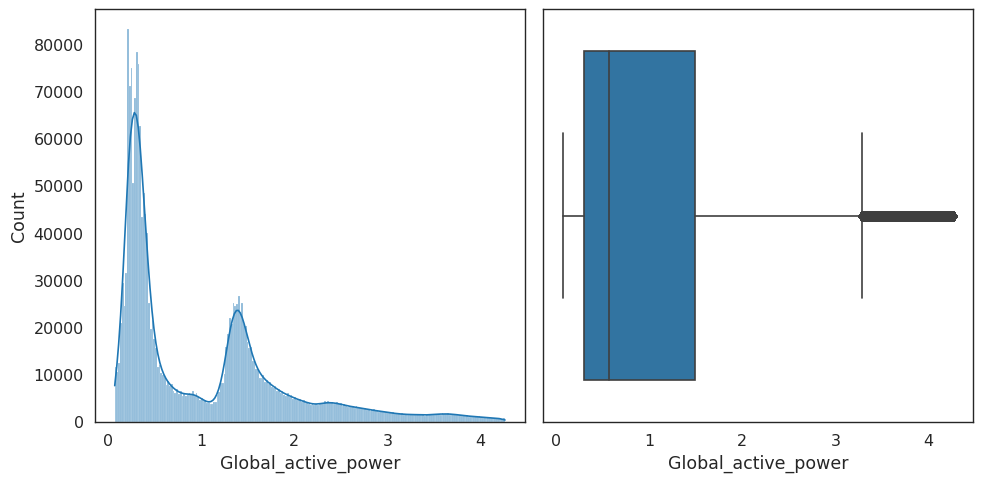

In [ ]:
# Create a 1x2 grid for the subplots (1 row, 2columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the distribution of each power in separate subplots
sns.histplot(df3['Global_active_power'], kde=True, ax=axes[0])


# Box Plot
sns.boxplot(x=df3['Global_active_power'], ax=axes[1])


# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
print('The shape of the DataFrame without outliers :' ,df1.shape)
print('\nThe shape of the DataFrame with outliers :' ,df3.shape, '\n')

The shape of the DataFrame without outliers : (2049280, 8)

The shape of the DataFrame with outliers : (2013120, 8) 



--> df = data base from scratch

--> df1 = df without missing and duplicate values

--> df3= df1 without outliers

###**Data Preparation**

Create new columns for year, quarter, month, and day

In [ ]:
#create column month
def month(x):
    return x.month
df3['month'] = df3['date_time'].apply(lambda x: month(x))

In [ ]:
#create column year
def year(x):
    return x.year
df3['year'] = df3['date_time'].apply(lambda x: year(x))

In [ ]:
#create column quarter
def quarter(x):
    return x.quarter
df3['quarter'] = df3['date_time'].apply(lambda x: quarter(x))

In [ ]:
#create column day
def day(x):
    return x.day
df3['day'] = df3['date_time'].apply(lambda x: day(x))

In [ ]:
# Create a new column 'weekday' that indicates if the day is a weekday (1) or weekend (0)
df3['weekday'] = df3['date_time'].apply(lambda x: x.weekday() < 5).astype(int)

In [ ]:
# Feature Engineering - Creation of new Feature 'Power Consumption'

eq1 = (df3['Global_active_power']*1000/60)
eq2 = df3['Sub_metering_1'] + df3['Sub_metering_2'] + df3['Sub_metering_3']
df3['Pw'] = (eq1 - eq2)

In [ ]:
print(df3.dtypes)

Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
date_time                datetime64[ns]
month                             int64
year                              int64
quarter                           int64
day                               int64
weekday                           int64
Pw                              float64
dtype: object


In [ ]:
df3.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,date_time,month,year,quarter,day,weekday,Pw
0,4.2160,0.4180,234.8400,18.4000,0.0000,1.0000,17.0000,2006-12-16 17:24:00,12,2006,4,16,0,52.2667
4,3.6660,0.5280,235.6800,15.8000,0.0000,1.0000,17.0000,2006-12-16 17:28:00,12,2006,4,16,0,43.1000
5,3.5200,0.5220,235.0200,15.0000,0.0000,2.0000,17.0000,2006-12-16 17:29:00,12,2006,4,16,0,39.6667
6,3.7020,0.5200,235.0900,15.8000,0.0000,1.0000,17.0000,2006-12-16 17:30:00,12,2006,4,16,0,43.7000
7,3.7000,0.5200,235.2200,15.8000,0.0000,1.0000,17.0000,2006-12-16 17:31:00,12,2006,4,16,0,43.6667


In [ ]:
df3.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,month,year,quarter,day,weekday,Pw
count,2013120.0000,2013120.0000,2013120.0000,2013120.0000,2013120.0000,2013120.0000,2013120.0000,2013120.0000,2013120.0000,2013120.0000,2013120.0000,2013120.0000,2013120.0000
mean,1.0178,0.1219,240.9270,4.3135,0.7689,0.9862,6.3080,6.4945,2008.4310,2.5008,15.6697,0.7188,8.8995
std,0.9033,0.1105,3.1748,3.7769,4.9409,4.3536,8.3889,3.4361,1.1234,1.1155,8.8352,0.4496,8.7806
min,0.0760,0.0000,223.2000,0.2000,0.0000,0.0000,0.0000,1.0000,2006.0000,1.0000,1.0000,0.0000,-2.4000
25%,0.3060,0.0480,239.1000,1.4000,0.0000,0.0000,0.0000,4.0000,2007.0000,2.0000,8.0000,0.0000,3.8000
50%,0.5700,0.1000,241.0600,2.6000,0.0000,0.0000,1.0000,7.0000,2008.0000,3.0000,16.0000,1.0000,5.4333
75%,1.4980,0.1920,242.9200,6.2000,0.0000,1.0000,17.0000,9.0000,2009.0000,3.0000,23.0000,1.0000,9.9333
max,4.2620,1.2740,254.1500,19.8000,61.0000,69.0000,31.0000,12.0000,2010.0000,4.0000,31.0000,1.0000,71.0333


###**Testing for Normality**

In [ ]:
!pip install stats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stats: filename=stats-0.1.2a0-py3-none-any.whl size=24282 sha256=9b976a78ec59911034035315b901bfa33cf9d81fd83ebedfe38d2332cd0b0ae5
  Stored in directory: /root/.cache/pip/wheels/c9/85/bc/3371b9bce1e4f7b8b638e8c968a4dbd74db171ee180c48f808
Successfully built stats


We will use D’Agostino’s K^2 Test to determine if our data is normally distributed. In the SciPy implementation of the test, the p-value will be used to make the following interpretation:

If p <= alpha(usually set at 0.05 or 5% level of significance), we will reject the null hypothesis (H0) and conclude that the data is not normally distributed.

If p > alpha, we will fail to reject the null hypothesis and conclude that the data is normal.

In [ ]:
# Test for Normality of the Global Active Power Data

# Import the required libraries
import scipy.stats as stats

In [ ]:
# Calculate the test statistics and p-value
stat, p = stats.normaltest(df3.Global_active_power)

# Print the results

print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=359905.983, p=0.000


In [ ]:
# Set the significance level
alpha = 0.05

# Make a decision on the test result
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Data does not look Gaussian (reject H0)


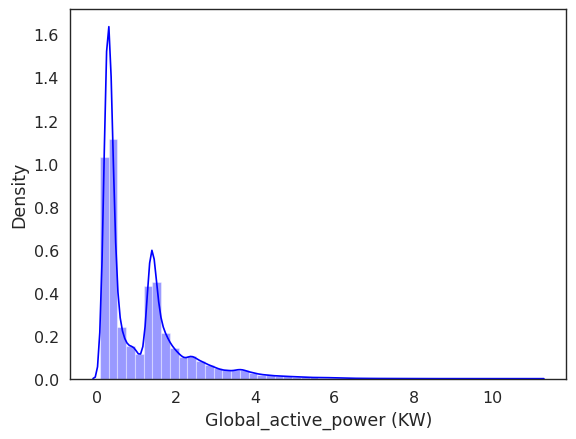

In [ ]:
sns.distplot(df1.Global_active_power,color='blue',norm_hist=True)

# Nommer l'abscisse (axe x)
plt.xlabel('Global_active_power (KW)')
# Nommer l'ordonnée (axe y)
plt.ylabel('Density')
plt.show()

In [ ]:
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df1.Global_active_power)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df1.Global_active_power)))

Kurtosis of normal distribution: 4.218671866132123
Skewness of normal distribution: 1.7862320846320818


The kurtosis of a normal distribution is close to zero, and if the kurtosis is greater than zero, the distribution has heavier tails.

On the other hand, skewness measures the symmetry of the distribution. If the skewness is between -0.5 and 0.5, the data is considered fairly symmetrical.

However, if the skewness falls between -1 and -0.5 or between 0.5 and 1, the data is considered moderately skewed.

Lastly, if the skewness is less than -1 or greater than 1, the data is considered highly skewed. In this particular case, the skewness value is greater than 1, indicating a highly skewed distribution.

### **Analysis from visualzation**

Now let's visualize the data and check the relationship of 'Global_active_power' with 'Year' , 'Month' and 'Hour' with line and bar graphs.

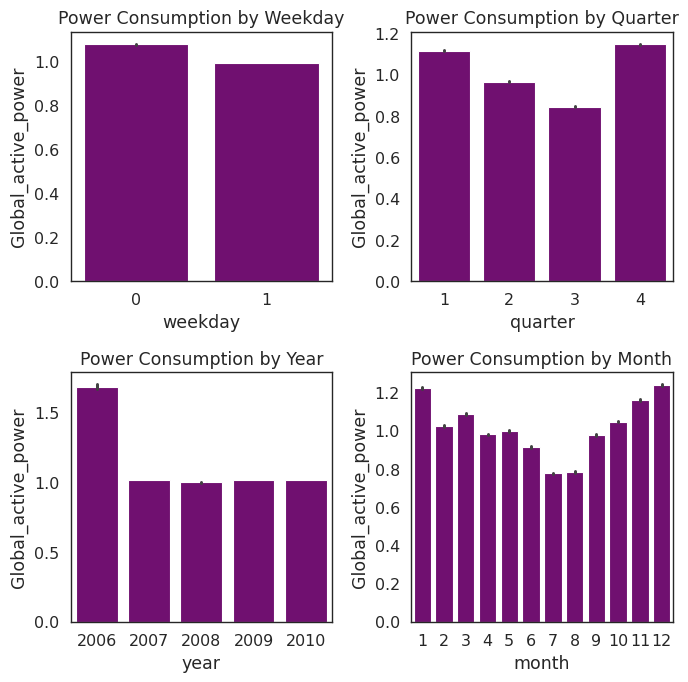

In [ ]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(7,7))


# Plot the first bar plot for 'year' vs. 'Global_active_power'
sns.barplot(x="year", y="Global_active_power", data=df3, ax=axes[1, 0],color='purple')
axes[1, 0].set_ylabel('Global_active_power')
axes[1, 0].set_title('Power Consumption by Year')

# Plot the second bar plot for 'quarter' vs. 'Global_active_power'
sns.barplot(x="quarter", y="Global_active_power", data=df3, ax=axes[0, 1],color='purple')
axes[0, 1].set_ylabel('Global_active_power')
axes[0, 1].set_title('Power Consumption by Quarter')

# Plot the  third bar plot for 'month' vs. 'Global_active_power'
sns.barplot(x="month", y="Global_active_power", data=df3, ax=axes[1, 1],color='purple')
axes[1, 1].set_ylabel('Global_active_power')
axes[1, 1].set_title('Power Consumption by Month')


# Plot the fourth bar plot for 'weekday' vs. 'Global_active_power'
sns.barplot(x="weekday", y="Global_active_power", data=df3, ax=axes[0, 0],color='purple')
axes[0, 0].set_ylabel('Global_active_power')
axes[0, 0].set_title('Power Consumption by Weekday')


# Adjust the layout and spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


When we compare the plot side by side for each year, we notice that the median global active power in 2006 appears to be much higher than in other years.

However, this observation may be misleading as we only have data for December of 2006, which is typically the highest month for household electricity consumption.

This pattern is also reflected in the quarterly median global active power, which is higher during the first and fourth quarters (winter) and lowest during the third quarter (summer).

In [ ]:
data1=df3.loc[:,['date_time','Global_active_power']]
data1.set_index('date_time',inplace=True)

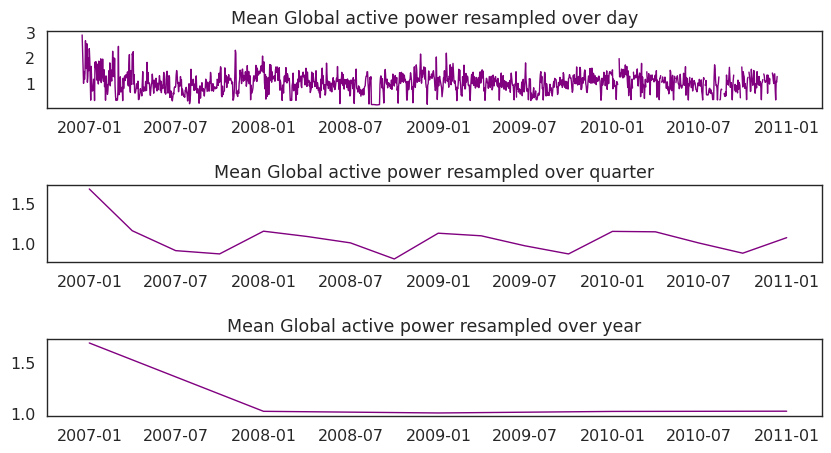

In [ ]:
# Create a figure with specified size
fig = plt.figure(figsize=(10,5))
# Adjust the subplot spacing
fig.subplots_adjust(hspace=1)

# Create first subplot
ax1 = fig.add_subplot(3,1,1)
# Plot the resampled mean of Global_active_power over day with different color
ax1.plot(data1['Global_active_power'].resample('D').mean(), linewidth=1, color='purple')
# Set the title for the subplot
ax1.set_title('Mean Global active power resampled over day')
# Set major tick parameters for the subplot
ax1.tick_params(axis='both', which='major')


# Create second subplot
ax4  = fig.add_subplot(3,1,2, sharex=ax1)
# Plot the resampled mean of Global_active_power over month with different color
ax4.plot(data1['Global_active_power'].resample('Q').mean(),linewidth=1, color='purple')
# Set the title for the subplot
ax4.set_title('Mean Global active power resampled over quarter')
# Set major tick parameters for the subplot
ax4.tick_params(axis='both', which='major')


# Create third subplot
ax5  = fig.add_subplot(3,1,3, sharex=ax1)
# Plot the resampled mean of Global_active_power over month with different color
ax5.plot(data1['Global_active_power'].resample('A').mean(),linewidth=1, color='purple')
# Set the title for the subplot
ax5.set_title('Mean Global active power resampled over year')
# Set major tick parameters for the subplot
ax5.tick_params(axis='both', which='major')

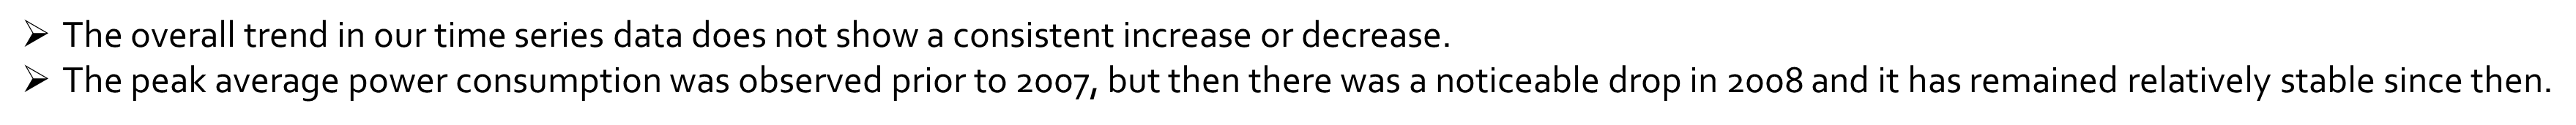

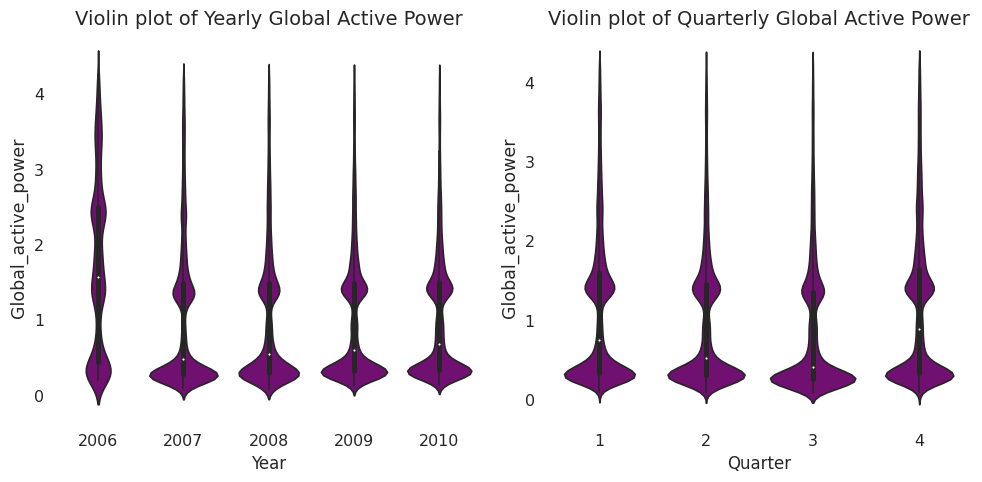

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 2 subplots
plt.figure(figsize=(10,5))

# Plot the first subplot showing the violinplot of yearly global active power
plt.subplot(1,2,1)
# Adjust the subplot's width
plt.subplots_adjust(wspace=0.2)
# Create the violinplot using Seaborn's violinplot function
sns.violinplot(x="year", y="Global_active_power", data=df3, color='purple')
# Label the x-axis
plt.xlabel('Year', fontsize=12)
# Add a title to the plot
plt.title('Violin plot of Yearly Global Active Power', fontsize=14)
# Remove the top and right spines of the plot
sns.despine(left=True, bottom=True)
# Add a tight layout to the plot
plt.tight_layout()

# Plot the second subplot showing the violinplot of quarterly global active power
plt.subplot(1,2,2)
# Create the violinplot using Seaborn's violinplot function
sns.violinplot(x="quarter", y="Global_active_power", data=df3, color='purple')
# Label the x-axis
plt.xlabel('Quarter', fontsize=12)
# Add a title to the plot
plt.title('Violin plot of Quarterly Global Active Power', fontsize=14)
# Remove the top and right spines of the plot
sns.despine(left=True, bottom=True)
# Add a tight layout to the plot
plt.tight_layout()

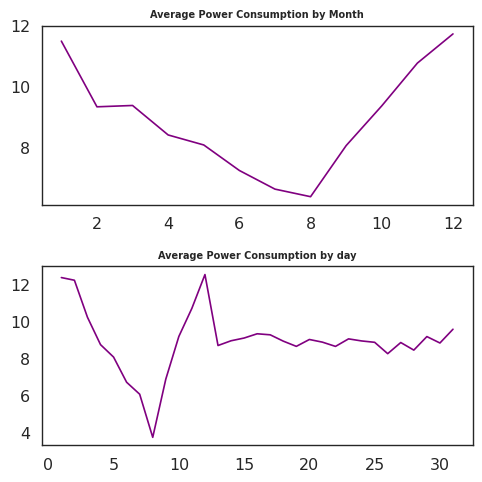

In [ ]:
# Import the matplotlib library for plotting graphs
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 2 columns and set its size to 14x8
plt.figure(figsize=(5,5))


# Third subplot in the second row, first column
plt.subplot(2,1,1)
# Group df3 by month and take the mean of the 'Pw' column
grouped_by_month = df3.groupby('month').Pw.agg('mean')
# Plot the mean of 'Pw' by month with purple color
grouped_by_month.plot(color='purple')
# Set the x label to be empty
plt.xlabel('')
# Set the title to 'Average Power Consumption by Month' with font size 12 and font weight 'bold'
plt.title('Average Power Consumption by Month', fontsize=7, fontweight='bold')

# Fourth subplot in the second row, second column
plt.subplot(2,1,2)
# Group df3 by day and take the mean of the 'Pw' column
grouped_by_day = df3.groupby('day').Pw.agg('mean')
# Plot the mean of 'Pw' by day with green color
grouped_by_day.plot(color='purple')
# Set the x label to be empty
plt.xlabel('')
# Set the title to 'Average Power Consumption by Day' with font size 12 and font weight 'bold'
plt.title('Average Power Consumption by day', fontsize=7, fontweight='bold')

# Use tight_layout to adjust the subplots so that they fit into the figure area
plt.tight_layout()

# Show the plot
plt.show()

The visualization of the data has reinforced our previous observations.

We observed that the average power consumption was the highest prior to 2007, and it has remained consistent since then. We also found that the lowest average power consumption was recorded in the third quarter.

Additionally, the months of July and August recorded the lowest average power consumption, and the lowest daily average was recorded around the 8th of the month (the reason for this is unknown

array([[<Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>],
       [<Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>],
       [<Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>]], dtype=object)

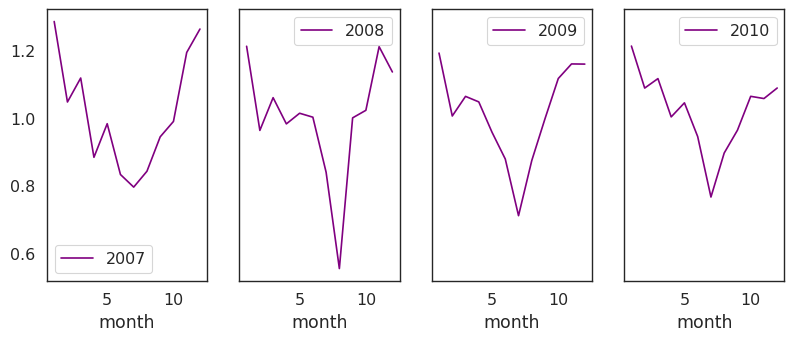

In [ ]:
#We remove 2006 because other years have similar pattern.
pd.pivot_table(df3.loc[df3['year']!=2006],values='Global_active_power',columns='year',index='month').plot(subplots=True,figsize=(12,12),layout=(3,5),sharey=True,color='purple')

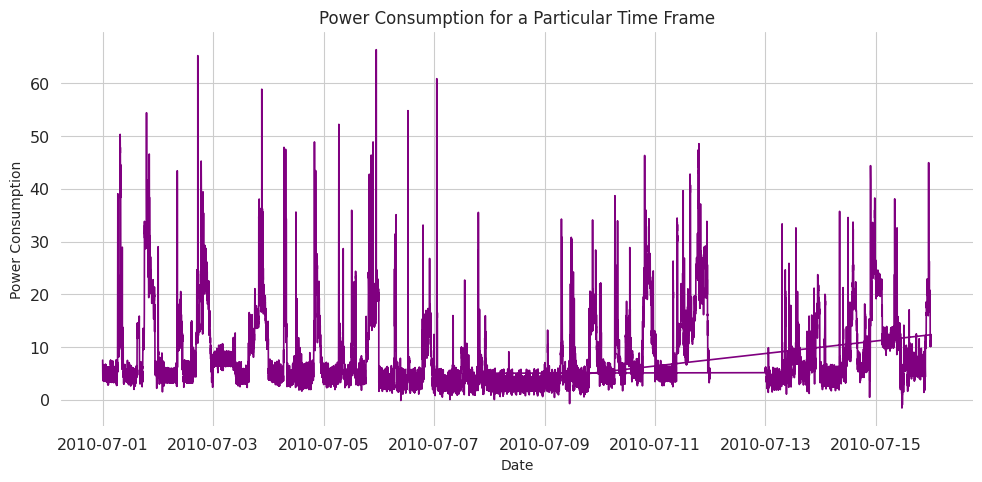

In [ ]:
df31 = df3[(df3.date_time >= '2010-07-01') & (df3.date_time < '2010-7-16')]

plt.figure(figsize=(10,5))
plt.plot(df31.date_time, df31.Pw, color='purple')
plt.ylabel('Power Consumption', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.title('Power Consumption for a Particular Time Frame', fontsize=12)
plt.tight_layout()
plt.grid(True)
sns.despine(bottom=True, left=True)
plt.show()

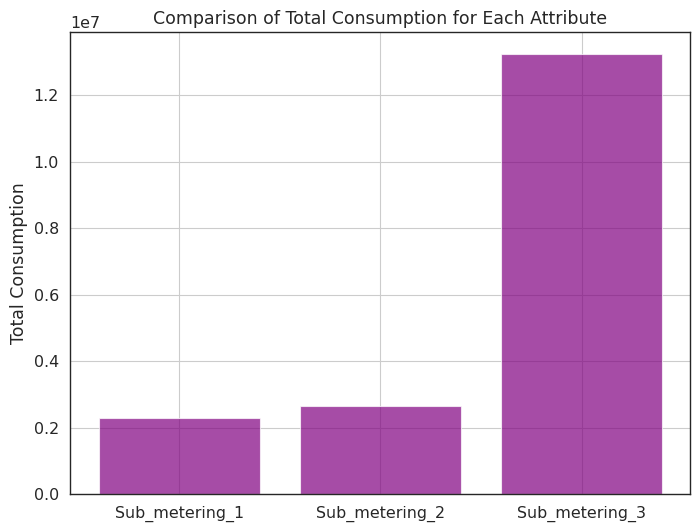

In [ ]:
# Calculate the sum of consumption for each attribute
s1= df['Sub_metering_1'].sum()
s2 = df['Sub_metering_2'].sum()
s3 = df['Sub_metering_3'].sum()

# List of attribute names
attributes = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# List of sum of consumption for each attribute
sum_consumption = [s1, s2, s3]

# Create the grouped bar plot to compare the consumption of each attribute
plt.figure(figsize=(8, 6))
plt.bar(attributes, sum_consumption, color='purple', alpha=0.7)
plt.ylabel('Total Consumption')
plt.title('Comparison of Total Consumption for Each Attribute')
plt.grid(True)
plt.show()

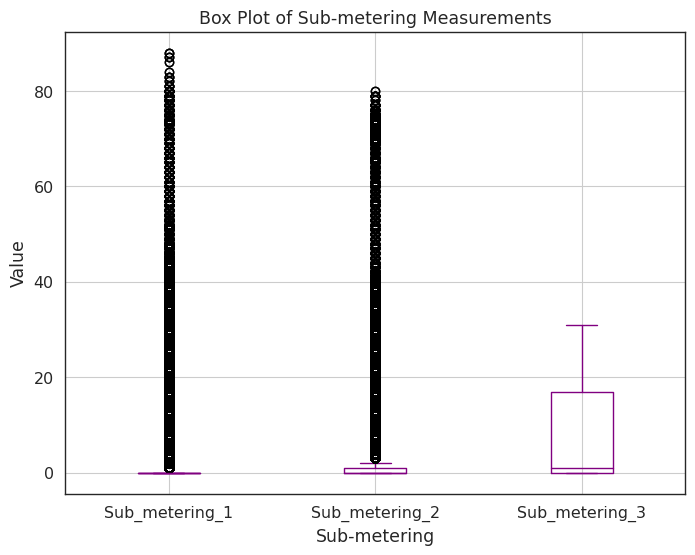

In [ ]:
sub_metering_cols = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
plt.figure(figsize=(8, 6))
df[sub_metering_cols].boxplot(color='purple')
plt.xlabel('Sub-metering')
plt.ylabel('Value')
plt.title('Box Plot of Sub-metering Measurements')
plt.show()

<Axes: >

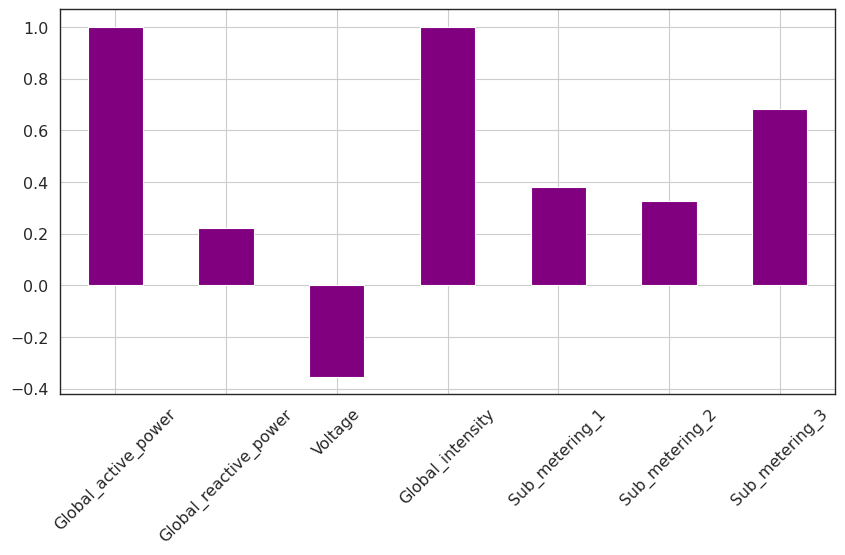

In [ ]:
plt.figure(figsize=(10,5))
df.corrwith(df3['Global_active_power']).plot.bar(grid=True,rot=45,color='purple')

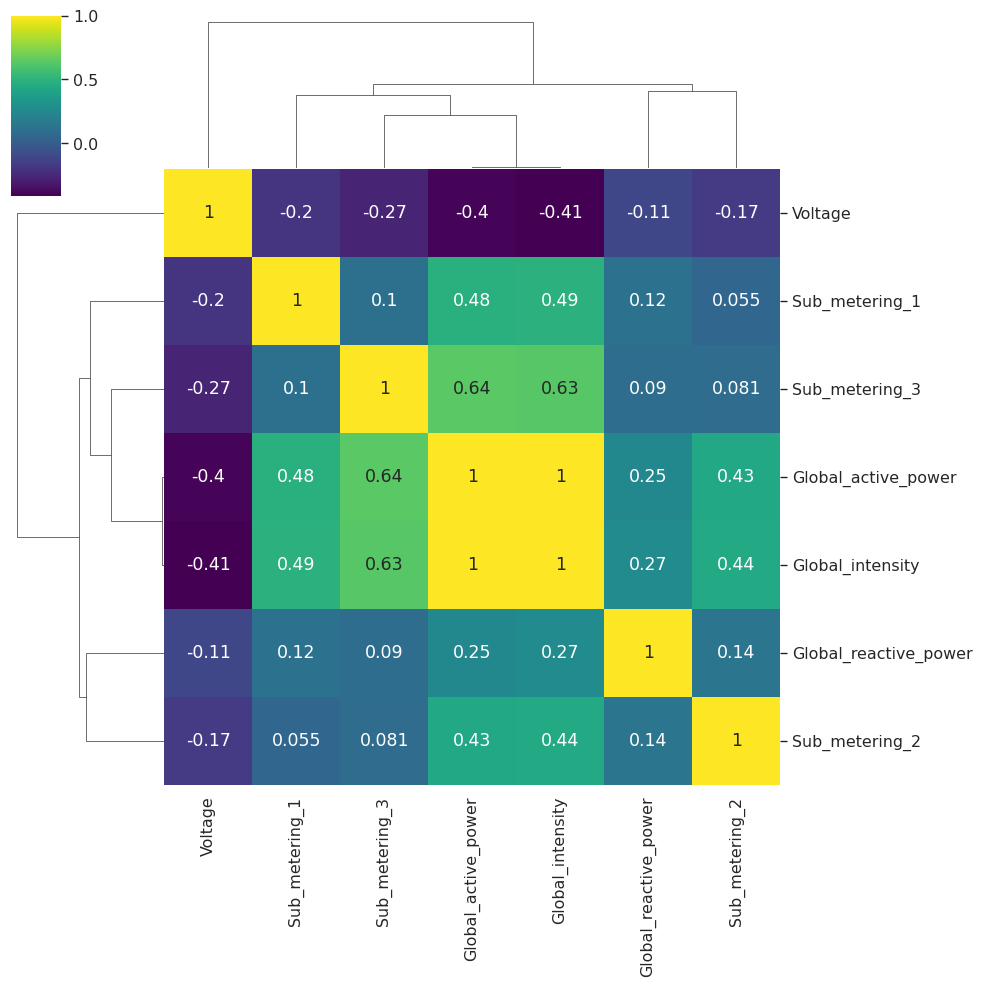

In [ ]:
sns.clustermap(df.corr(),cmap='viridis',annot=True,color='purple')

In [ ]:
df3.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,date_time
0,4.2160,0.4180,234.8400,18.4000,0.0000,1.0000,17.0000,2006-12-16 17:24:00
4,3.6660,0.5280,235.6800,15.8000,0.0000,1.0000,17.0000,2006-12-16 17:28:00
5,3.5200,0.5220,235.0200,15.0000,0.0000,2.0000,17.0000,2006-12-16 17:29:00
6,3.7020,0.5200,235.0900,15.8000,0.0000,1.0000,17.0000,2006-12-16 17:30:00
7,3.7000,0.5200,235.2200,15.8000,0.0000,1.0000,17.0000,2006-12-16 17:31:00


In [ ]:
def test_stationarity(timeseries):
    # Calculate rolling mean and standard deviation
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()

    # Plot original timeseries, rolling mean, and rolling standard deviation
    plt.figure(figsize=(20,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='purple',label='Original')
    mean = plt.plot(rolmean, color='yellow', label='Rolling Mean')
    std = plt.plot(rolstd, color='cyan', label = 'Rolling Std')

    # Add legend
    plt.legend(loc='best')
    # Add title
    plt.title('Rolling Mean & Standard Deviation of Global Active Power')
    plt.show()

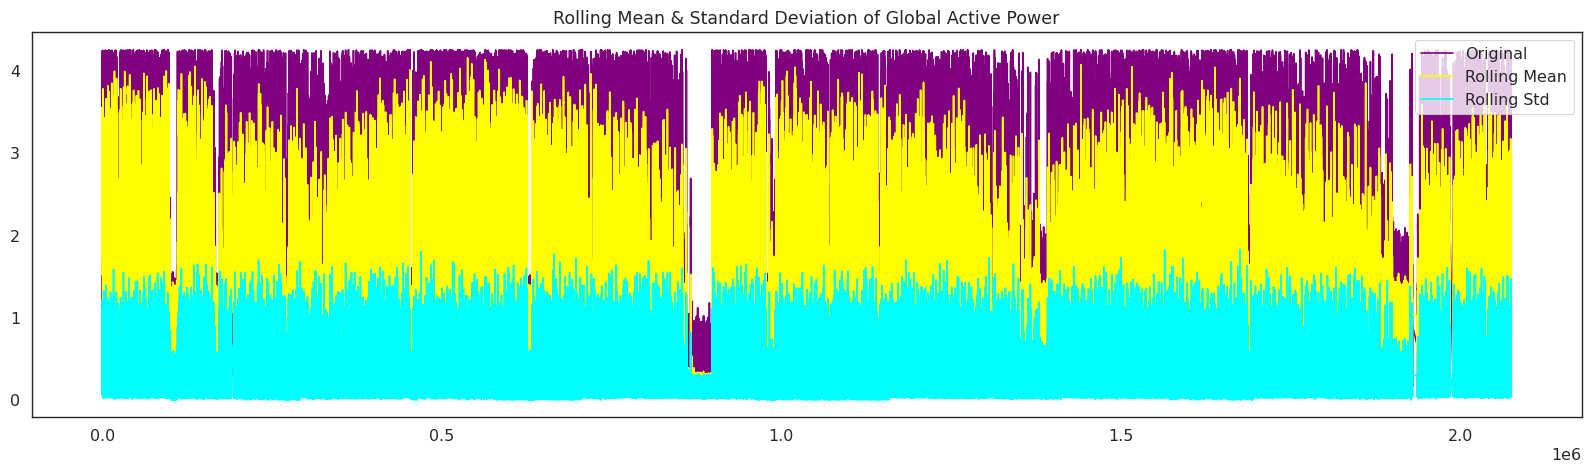

In [ ]:
test_stationarity(df4.Global_active_power.dropna())

In [ ]:
df4=df3[df3['date_time'].dt.year>=2007]

In [ ]:
df4.shape

(1992500, 8)

##**Modeling and evaluation**

In [ ]:
X = df4.drop(['Global_active_power','date_time'], axis=1)
y = df4['Global_active_power']

In [ ]:
#Split the transformed data into a training set (80%) and a test set (20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
#feature scaling
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train2 = pd.DataFrame(scaler.fit_transform(X_train))
X_test2 = pd.DataFrame(scaler.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2

In [ ]:
X_train.shape

(1494375, 6)

##1.Linear Regression

Linear regression is a statistical method that is used to model the relationship between a dependent variable and one or more independent variables. The dependent variable is the variable that you are trying to predict, and the independent variables are the variables that you are using to predict the dependent variable.

In [ ]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X_train, y_train)

LinearRegression()

In [ ]:
LR_predictions = LR.predict(X_test)

In [ ]:
from sklearn import metrics
print('Results of Linear Regression:\n')
print('Mean Absolute Error:',metrics.mean_absolute_error(y_test,LR_predictions))
print('Mean Squared Error:',metrics.mean_squared_error(y_test,LR_predictions))
print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(y_test,LR_predictions)))

Results of Linear Regression:

Mean Absolute Error: 0.02488980840794262
Mean Squared Error: 0.0015287411660923106
Root Mean Squared Error: 0.039099119761093225


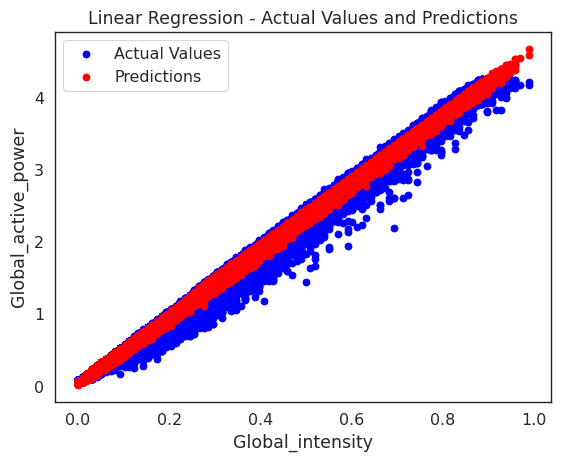

In [ ]:
plt.scatter(X_test['Global_intensity'], y_test, color='blue', label='Actual Values')

plt.scatter(X_test['Global_intensity'], LR_predictions, color='red', label='Predictions')

plt.xlabel('Global_intensity')
plt.ylabel('Global_active_power')
plt.title('Linear Regression - Actual Values and Predictions')
plt.legend()
plt.show()

In [ ]:
LR=0.039099119761093225

##2.Deep Neural Network

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
model=Sequential()
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='rmsprop',loss='mse')

In [ ]:
X_train=X_train.values;
y_train=y_train.values;
X_test=X_test.values;
y_test=y_test.values;

In [ ]:
print(X_train.shape,y_test.shape)

(1494375, 6) (498125,)


In [ ]:
model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

Epoch 1/100
46700/46700 [==============================] - 254s 5ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 2/100
46700/46700 [==============================] - 221s 5ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/100
46700/46700 [==============================] - 188s 4ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 4/100
46700/46700 [==============================] - 187s 4ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 5/100
46700/46700 [==============================] - 186s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/100
46700/46700 [==============================] - 187s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/100
46700/46700 [==============================] - 187s 4ms/step - loss: 0.0011 - val_loss: 9.9442e-04
Epoch 8/100
46700/46700 [==============================] - 192s 4ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 9/100
46700/46700 [==============================] - 171s 4ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/100
46700/46700 [=======

In [ ]:
predictions_neural=model.predict(X_test)

15567/15567 [==============================] - 24s 2ms/step


In [ ]:
from sklearn import metrics
print('Results of Deep Neural Network:\n')
print('Mean Absolute Error:',metrics.mean_absolute_error(y_test,predictions_neural))
print('Mean Squared Error:',metrics.mean_squared_error(y_test,predictions_neural))
print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(y_test,predictions_neural)))

Results of Deep Neural Network:

Mean Absolute Error: 0.024757849391712303
Mean Squared Error: 0.001271287000883214
Root Mean Squared Error: 0.0356551118478573


In [ ]:
X_test.shape

(498125, 6)

In [ ]:
plt.scatter(X_test['Global_intensity'], y_test, color='blue', label='Actual Values')

plt.scatter(X_test['Global_intensity'], predictions_neural, color='red', label='Predictions')

plt.xlabel('Global_intensity')
plt.ylabel('Global_active_power')
plt.title('dnn - Actual Values and Predictions')
plt.legend()
plt.show()

IndexError: ignored

In [ ]:
DNN=np.sqrt(metrics.mean_squared_error(y_test,predictions_neural))

In [ ]:
DNN=0.0189551118478573

##3.MLP Regressor

Multi-layer perceptron regressor (MLP Regressor) is a supervised learning algorithm that can be used to create predictive models. It is a type of neural network that uses a series of layers to learn the relationship between the input and output variables. MLP Regressor is a powerful algorithm that can be used to model a wide variety of data. It is also very robust to noise and outliers. However, it can be computationally expensive, especially for large datasets.

In [ ]:
from sklearn.neural_network import MLPRegressor
mlp_reg = MLPRegressor()
mlp_reg.fit(X_train, y_train)

MLPRegressor()

In [ ]:
mlp_reg_predictions = mlp_reg.predict(X_test)

In [ ]:
from sklearn import metrics
print('Results of MLP Regressor:\n')
print('Mean Absolute Error:',metrics.mean_absolute_error(y_test,mlp_reg_predictions))
print('Mean Squared Error:',metrics.mean_squared_error(y_test,mlp_reg_predictions))
print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(y_test,mlp_reg_predictions)))

Results of MLP Regressor:

Mean Absolute Error: 0.020439170882889462
Mean Squared Error: 0.0010248218443623274
Root Mean Squared Error: 0.03201283874264085


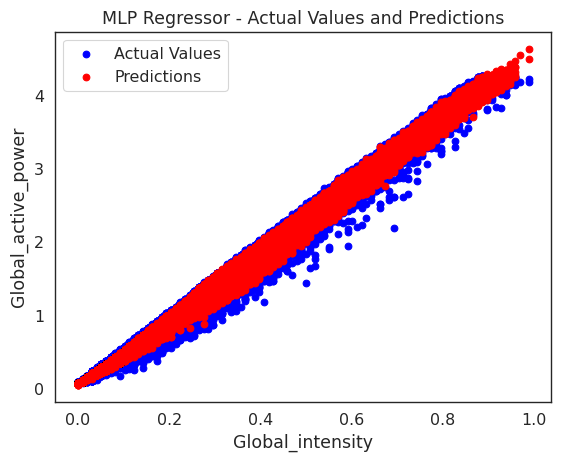

In [ ]:
plt.scatter(X_test['Global_intensity'], y_test, color='blue', label='Actual Values')

plt.scatter(X_test['Global_intensity'], mlp_reg_predictions, color='red', label='Predictions')

plt.xlabel('Global_intensity')
plt.ylabel('Global_active_power')
plt.title('MLP Regressor - Actual Values and Predictions')
plt.legend()
plt.show()

In [ ]:
MLPR=np.sqrt(metrics.mean_squared_error(y_test,mlp_reg_predictions))

In [ ]:
MLPR=0.03201283874264085

##4.XGBOOST

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
xgb_reg_predictions = xgb_reg.predict(X_test)

In [ ]:
from sklearn import metrics
print('Results of XGB:\n')
print('Mean Absolute Error:',metrics.mean_absolute_error(y_test,xgb_reg_predictions))
print('Mean Squared Error:',metrics.mean_squared_error(y_test,xgb_reg_predictions))
print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(y_test,xgb_reg_predictions)))

Results of XGB:

Mean Absolute Error: 0.017814174045354892
Mean Squared Error: 0.0008976955832612271
Root Mean Squared Error: 0.029961568437937743


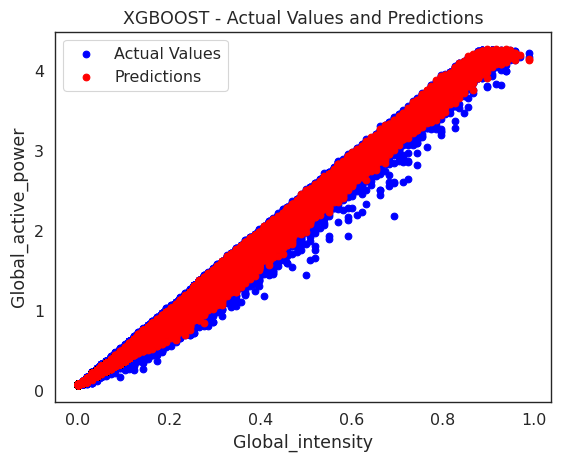

In [ ]:
plt.scatter(X_test['Global_intensity'], y_test, color='blue', label='Actual Values')

plt.scatter(X_test['Global_intensity'], xgb_reg_predictions, color='red', label='Predictions')

plt.xlabel('Global_intensity')
plt.ylabel('Global_active_power')
plt.title('XGBOOST - Actual Values and Predictions')
plt.legend()
plt.show()

In [ ]:
XGB=np.sqrt(metrics.mean_squared_error(y_test,xgb_reg_predictions))

In [ ]:
XGB=0.029961568437937743

##5.Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
decision_tree_reg = DecisionTreeRegressor()

In [ ]:
decision_tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
decision_tree_reg_predictions = decision_tree_reg.predict(X_test)

In [ ]:
from sklearn import metrics
print('Results of XGB:\n')
print('Mean Absolute Error:',metrics.mean_absolute_error(y_test,decision_tree_reg_predictions))
print('Mean Squared Error:',metrics.mean_squared_error(y_test,decision_tree_reg_predictions))
print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(y_test,decision_tree_reg_predictions)))

Results of XGB:

Mean Absolute Error: 0.022101076688906558
Mean Squared Error: 0.0016962976066911698
Root Mean Squared Error: 0.04118613367009787


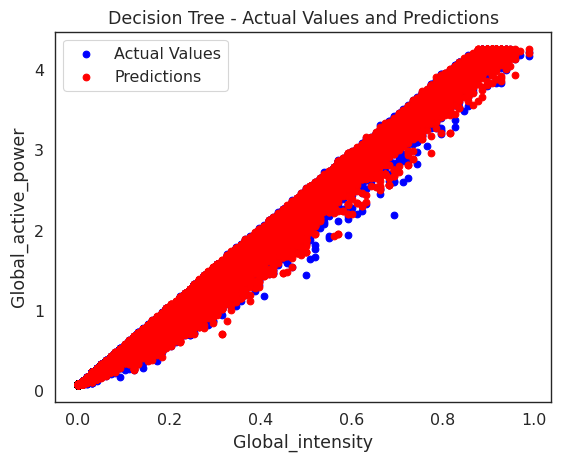

In [ ]:
plt.scatter(X_test['Global_intensity'], y_test, color='blue', label='Actual Values')

plt.scatter(X_test['Global_intensity'], decision_tree_reg_predictions, color='red', label='Predictions')

plt.xlabel('Global_intensity')
plt.ylabel('Global_active_power')
plt.title('Decision Tree - Actual Values and Predictions')
plt.legend()
plt.show()

In [ ]:
DTreeR=np.sqrt(metrics.mean_squared_error(y_test,decision_tree_reg_predictions))

In [ ]:
DTreeR=0.04118613367009787

##6.Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X_train, y_train)

In [ ]:
random_forest_reg_predictions = random_forest_reg.predict(X_test)

In [ ]:
from sklearn import metrics
print('Results of XGB:\n')
print('Mean Absolute Error:',metrics.mean_absolute_error(y_test,random_forest_reg_predictions))
print('Mean Squared Error:',metrics.mean_squared_error(y_test,random_forest_reg_predictions))
print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(y_test,random_forest_reg_predictions)))

In [ ]:
plt.scatter(X_test['Global_intensity'], y_test, color='blue', label='Actual Values')

plt.scatter(X_test['Global_intensity'], random_forest_reg_predictions, color='red', label='Predictions')

plt.xlabel('Global_intensity')
plt.ylabel('Global_active_power')
plt.title('Random Forest Regressor - Actual Values and Predictions')
plt.legend()
plt.show()

In [ ]:
RFR=np.sqrt(metrics.mean_squared_error(y_test,random_forest_reg_predictions))

In [ ]:
RFR=0.03234714341385656

##7.ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(y_train, order=(1, 1, 1))
model_fit = model.fit()

In [ ]:
# Make predictions on the test set
predictions = model_fit.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, typ='levels')

In [ ]:
# Calculate RMSE
mse = mean_squared_error(y_test, predictions)
AR = np.sqrt(mse)
print("RMSE:", AR)

In [ ]:
AR=0.9027665635518012

##**Comparaison of models**

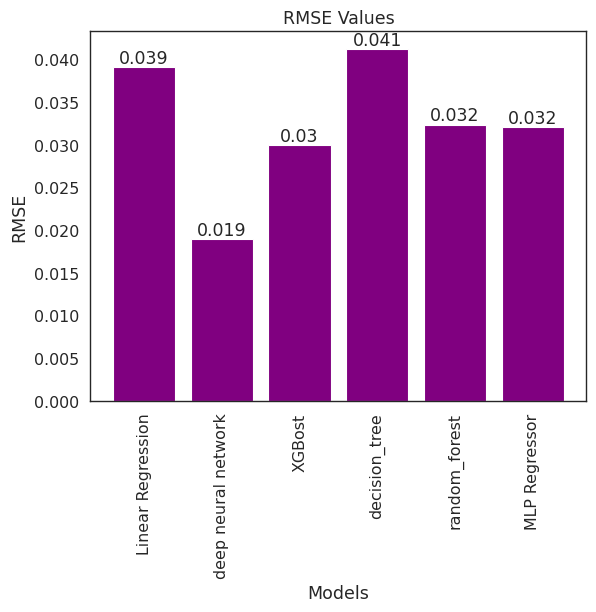

In [ ]:
rmse_values = [LR,
               DNN,
               XGB,
               DTreeR,
               RFR,
               MLPR
              ]

models = [     'Linear Regression',
          'deep neural network',
               'XGBost',
               'decision_tree',
               'random_forest','MLP Regressor'

         ]
plt.bar(models, rmse_values, color='purple')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Values')
plt.xticks(rotation=90)


for i in range(len(models)):
    plt.text(i, rmse_values[i], str(round(rmse_values[i], 3)), ha='center', va='bottom')

plt.show()

##**LSTM Modeling**

##Univariate multi step predection
##Encoder decoder lstm model

In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# Defining the LSTM model
model = Sequential()

# Adding the first layer with 100 LSTM units and input shape of the data
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))

# Adding a dropout layer to avoid overfitting
model.add(Dropout(0.2))

# Adding a dense layer with 1 unit to make predictions
model.add(Dense(1))

# Compiling the model with mean squared error as the loss function and using Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the model on training data and using early stopping to avoid overfitting
history = model.fit(X_train, Y_train, epochs=20, batch_size=1240, validation_data=(X_test, Y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=4)], verbose=1, shuffle=False)

# Displaying a summary of the model
model.summary()

Epoch 1/20
1286/1286 [==============================] - 10s 6ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 2/20
1286/1286 [==============================] - 6s 5ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 3/20
1286/1286 [==============================] - 7s 5ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 4/20
1286/1286 [==============================] - 7s 5ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 5/20
1286/1286 [==============================] - 7s 5ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 6/20
1286/1286 [==============================] - 7s 5ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 7/20
1286/1286 [==============================] - 7s 6ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 8/20
1286/1286 [==============================] - 8s 6ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 9/20
1286/1286 [==============================] - 7s 5ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 10/20
1286/1286 [==============================] - 8s 6ms/step - loss: 0.00

##**Evaluation**

In [ ]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

12453/12453 [==============================] - 27s 2ms/step


In [ ]:
def inv_scale(data, scaled_data, train_split):
    """
    Function to inverse scaling of data by using the mean and standard deviation of the training data only
    """
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)

    return scaled_data * data_std + data_mean

In [ ]:
univar_data = df3['Global_active_power'].values
test_size = 0.2
TRAIN_SPLIT = int(round(len(df3) * (1-test_size)))

In [ ]:
# Inverse scaling of prediction
test_predict = inv_scale(univar_data, test_predict, TRAIN_SPLIT)
# Inverse scaling of X_test, y_test
X_test = inv_scale(univar_data, X_test, TRAIN_SPLIT)
Y_test = inv_scale(univar_data, Y_test, TRAIN_SPLIT)

In [ ]:
from sklearn import metrics
print('Results of LSTM:\n')
print('Results of train')
print('Mean Absolute Error:',metrics.mean_absolute_error(Y_train,train_predict[:,0]))
print('Mean Squared Error:',metrics.mean_squared_error(Y_train,train_predict[:,0]))
print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(Y_train,train_predict[:,0])))

print('\nResults of test')
print('Mean Absolute Error:',metrics.mean_absolute_error(Y_test,test_predict[:,0]))
print('Mean Squared Error:',metrics.mean_squared_error(Y_test,test_predict[:,0]))
print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(Y_test,test_predict[:,0])))

Results of LSTM:

Results of train
Mean Absolute Error: 0.021036021
Mean Squared Error: 0.0030026012
Root Mean Squared Error: 0.054795995

Results of test
Mean Absolute Error: 0.019070288
Mean Squared Error: 0.00229839
Root Mean Squared Error: 0.04794153


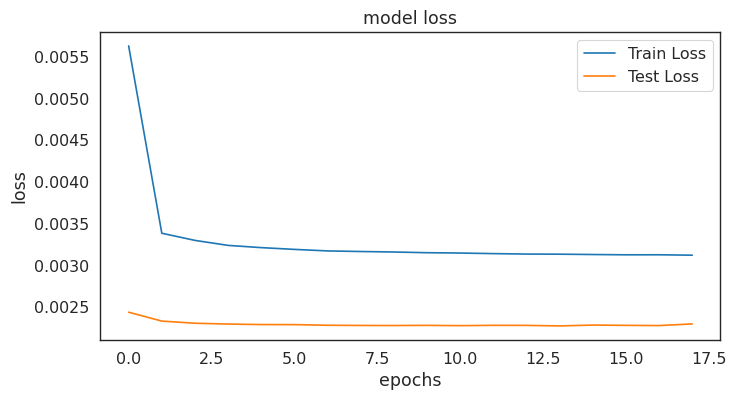

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();